In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sg
import xlrd

In [3]:
#1/3倍频程中心频率
freqs_3 = np.array([10e+01, 
                    1.25e+01, 1.60e+01, 2.00e+01, 2.50e+01, 3.15e+01, 4.00e+01, 
                    5.00e+01, 6.30e+01, 8.00e+01, 1.00e+02, 1.25e+02, 1.60e+02, 
                    2.00e+02, 2.50e+02, 3.15e+02, 4.00e+02, 5.00e+02, 6.30e+02, 
                    8.00e+02, 1.00e+03, 1.25e+03, 1.60e+03, 2.00e+03, 2.50e+03,
                    3.15e+03, 4.00e+03, 5.00e+03, 6.30e+03, 8.00e+03, 1.00e+04, 
                    1.25e+04, 1.60e+04,2.00e+04])
#p0
p0 = 2.00e-5
print(freqs_3 [3:33])

[   20.     25.     31.5    40.     50.     63.     80.    100.    125.
   160.    200.    250.    315.    400.    500.    630.    800.   1000.
  1250.   1600.   2000.   2500.   3150.   4000.   5000.   6300.   8000.
 10000.  12500.  16000. ]


In [3]:
#A计权系数
Wght_fct = np.array([-70.4,
                     -63.4, -56.7, -50.7, -44.7, -39.4, -34.6, 
                     -30.2, -26.2, -22.5, -19.1, -16.1, -13.4, 
                     -10.9, -8.6, -6.6, -4.8,  -3.2, - 1.9,
                     -0.8, 0.0, 0.6, 1.0, 1.2, 1.3,
                     1.2, 1.0, 0.5, -0.1, -1.1, -2.5,
                     -4.3, -6.6, -9.3])
#print(Wght_fct [3:33])

In [4]:
def nextpow2(max_ele):
    n = 0
    while 2**n < max_ele:
        n += 1
    return 2**n

In [5]:
def calculate(address, measure_frqs, freqs_order, Weighting_factor,channal):
    
    #读取数据
    workbook = xlrd.open_workbook(address)
    Data_sheet = workbook.sheets()[0] 
    #声压时程
    t = Data_sheet.col_values(0)
    p_t  = Data_sheet.col_values(channal)
    data_len = len(p_t)
    #plt.figure(figsize=(14,8), dpi=200)
    #plt.plot(t,p_t)
    
    #加汉宁窗(恢复系数为1.633)
    #p_t = 1.633 * np.hamming(data_len) * p_t
    p_t = 1.633 * np.hanning(data_len) * p_t
    nfft = nextpow2(data_len)
    p_f = np.fft.fft(p_t,nfft)
    fx =  measure_frqs/2 * np.linspace(0,1,nfft/2)
    w = 2 * np.abs(p_f[:int(nfft/2)]/data_len)
    #w = np.abs(np.abs(p_f[:int(nfft/2)]/data_len))
    #绘制频谱
    plt.figure(figsize=(14,8), dpi=200)
    plt.semilogx(fx,w)
    
    
    
     # 求取1/3频程起止频率
    f_start =  freqs_order * 2 ** (-1 / 6)  
    f_stop = freqs_order * 2 ** (1 / 6)  
    
    #print(f_start)
    #分频带滤波   
    
    m = len(freqs_order)-1
    y_out = np.zeros(m)
    #'''
    #print(index_start,index_end)
    for i in range(m):
        
        index_start = int(np.round(f_start[i]*nfft/measure_frqs))
        index_end = int(np.round(f_start[i+1]*nfft/measure_frqs))
        index_end = int(np.round(f_stop[i]*nfft/measure_frqs))
        #index_end = int(np.round(f_start[i+1]*nfft/measure_frqs))
        data = np.zeros(nfft,dtype=np.complex)
        data[index_start:index_end] = p_f[index_start:index_end]
        data[nfft-1-index_end:nfft-1-index_start] = p_f[nfft-1-index_end:nfft-1-index_start]
        if f_stop[i]>measure_frqs/2:
            y_out[i] = p0
        else:
            data_ifft = np.fft.ifft(data,nfft)
            y_out[i] = np.power(np.var(data_ifft[:data_len].real),0.5)
    
    #print(y_out)
    '''
    #for i in range(m):   
        index = np.where((fx >= f_start[i]) & (fx < f_stop[i]) & ( f_stop[i]<measure_frqs/2))  # 取交集
        data = np.zeros(int(nfft/2))
        
        data[index] = np.take(p_f, index)[0]
        u=data[::-1]
        data_a = np.append(data,u)
        
        if data_a.any() == 0:
            y_out[i] = p0
        else:
            data_ifft = np.fft.ifft(data_a,nfft)
            y_out[i] = np.power(np.var(data_ifft.real[:data_len]),0.5)
    print(y_out)
    '''
    y_out_1 = 10*np.log10(y_out**2/p0**2)
    y_out_A = 10*np.log10(np.power(10,(y_out_1+Wght_fct[3:33])/10))
    non_out = 10*np.log10(sum(np.power(10,y_out_1/10)))
    A_out = 10*np.log10(sum(np.power(10,(y_out_1+Wght_fct[3:33])/10)))
    
    return y_out_1, y_out_A,non_out,A_out 

D:\anaconda\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


number of chanal:  13
non= 97.65193469647484
[73.02112188 75.67387705 73.098023   73.37687734 82.28670595 73.68788311
 75.80516623 77.73266265 88.5599003  85.49167079 82.68004166 88.05986164
 89.49224877 84.38032308 89.06184774 87.22053971 87.03803691 84.13029353
 79.4932553  73.96348112 77.04951579 77.78288031 75.37567493 69.04676317
 67.60648389 63.49925907 60.04520738  0.          0.          0.        ]
A= 93.37571657328749
[22.32112188 30.97387705 33.698023   38.77687734 52.08670595 47.48788311
 53.30516623 58.63266265 72.4599003  72.09167079 71.78004166 79.45986164
 82.89224877 79.58032308 85.86184774 85.32053971 86.23803691 84.13029353
 80.0932553  74.96348112 78.24951579 79.08288031 76.57567493 70.04676317
 68.10648389 63.39925907 58.94520738 -2.5        -4.3        -6.6       ]
number of chanal:  14
non= 96.61534742421877
[80.02759346 79.77179912 78.83153252 76.2448228  81.79218166 75.51895652
 75.76534576 76.51092688 88.50679854 83.66681707 81.55526801 86.02322741
 87.6389031

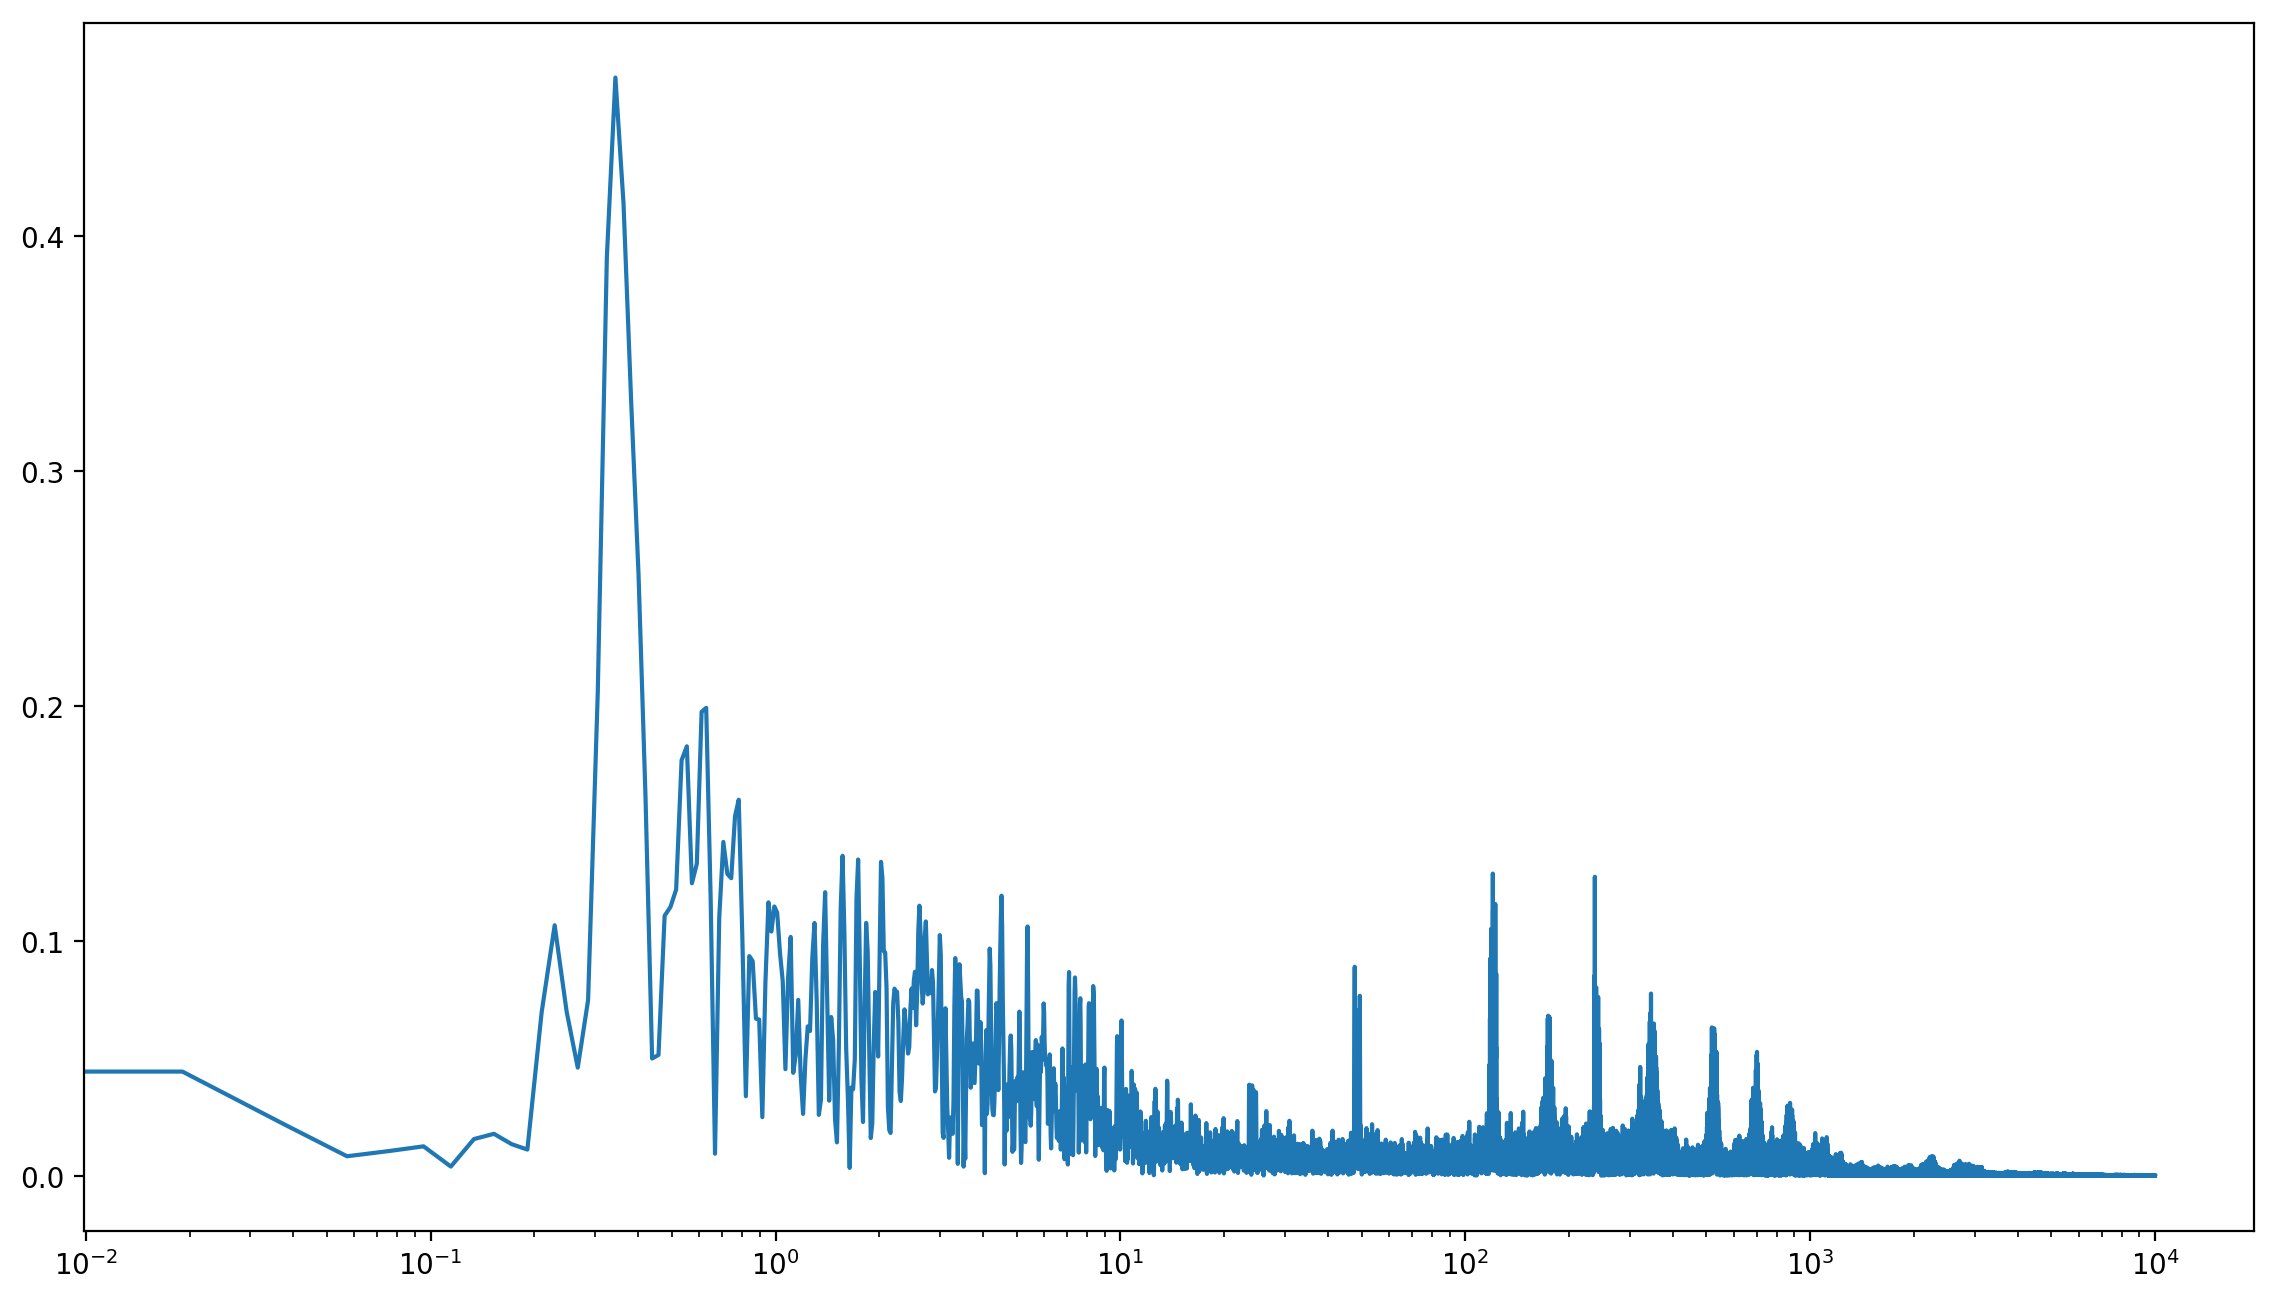

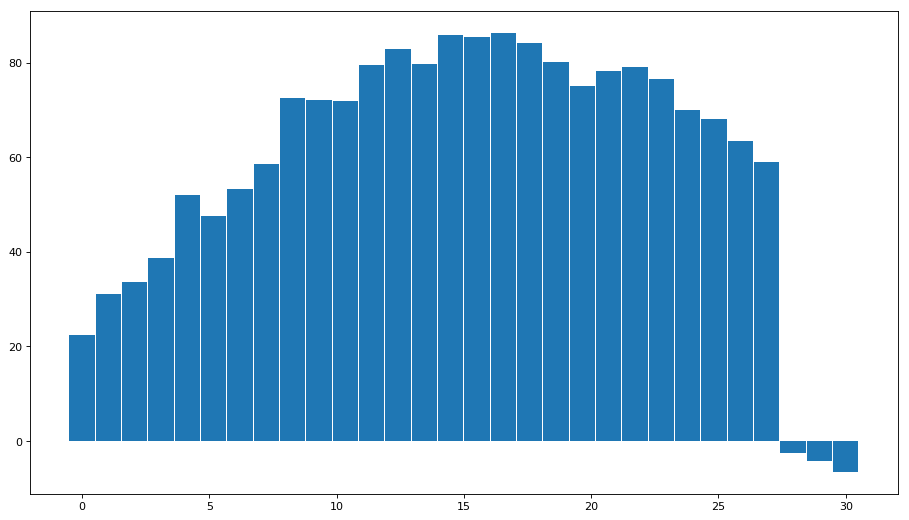

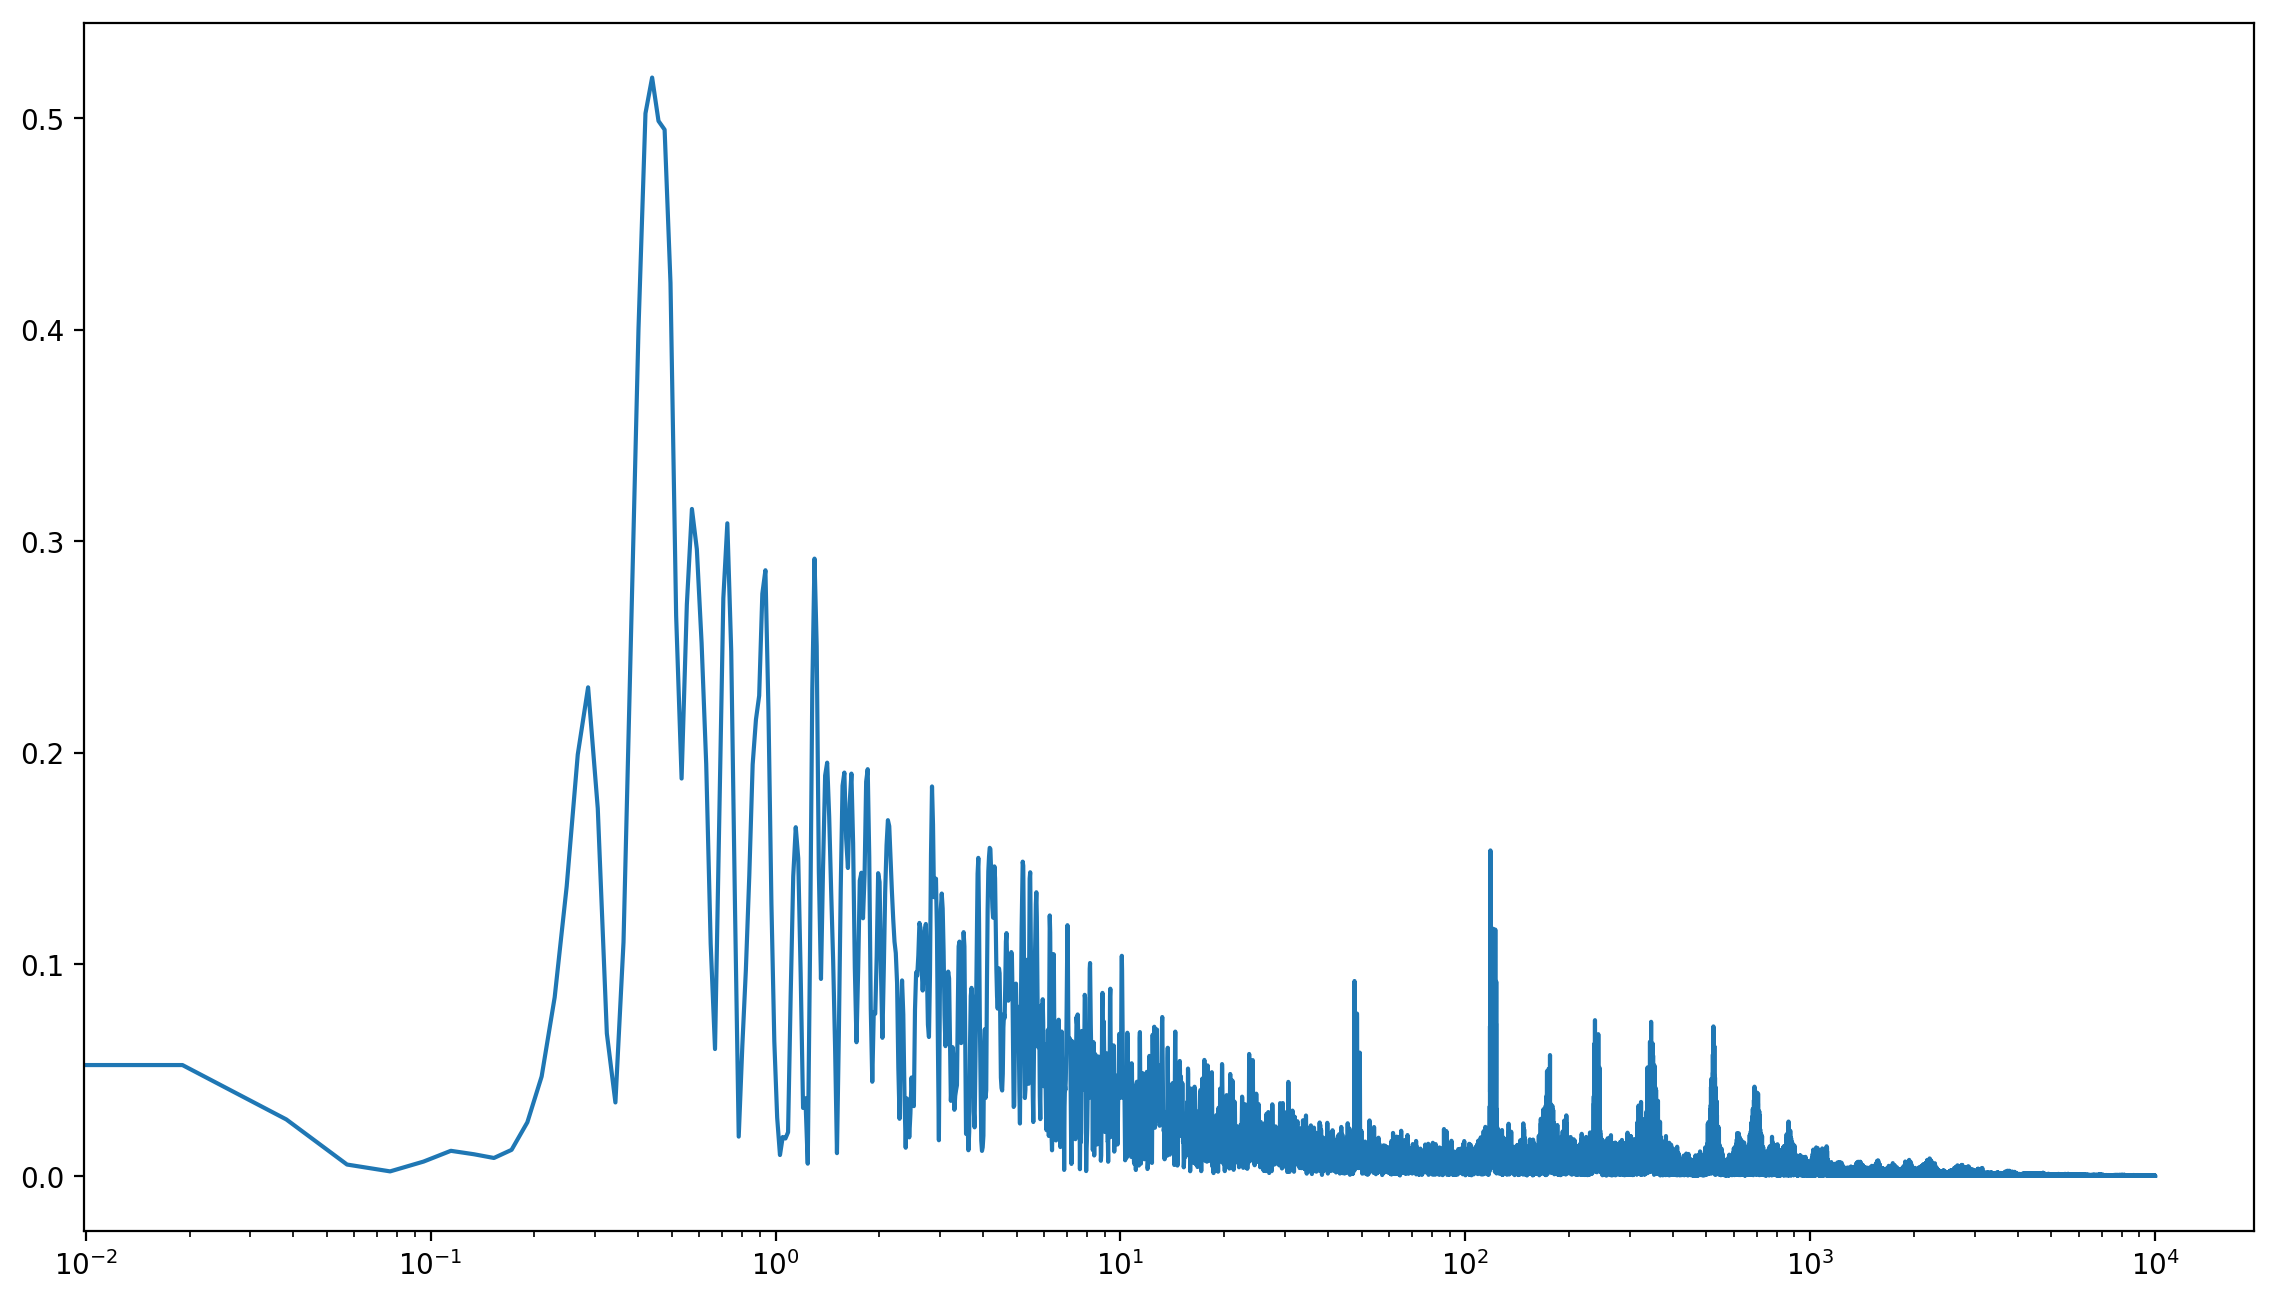

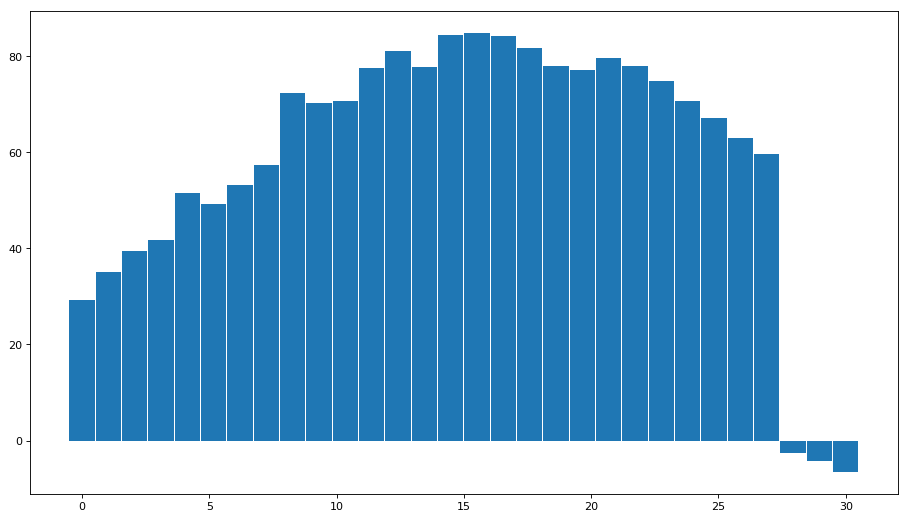

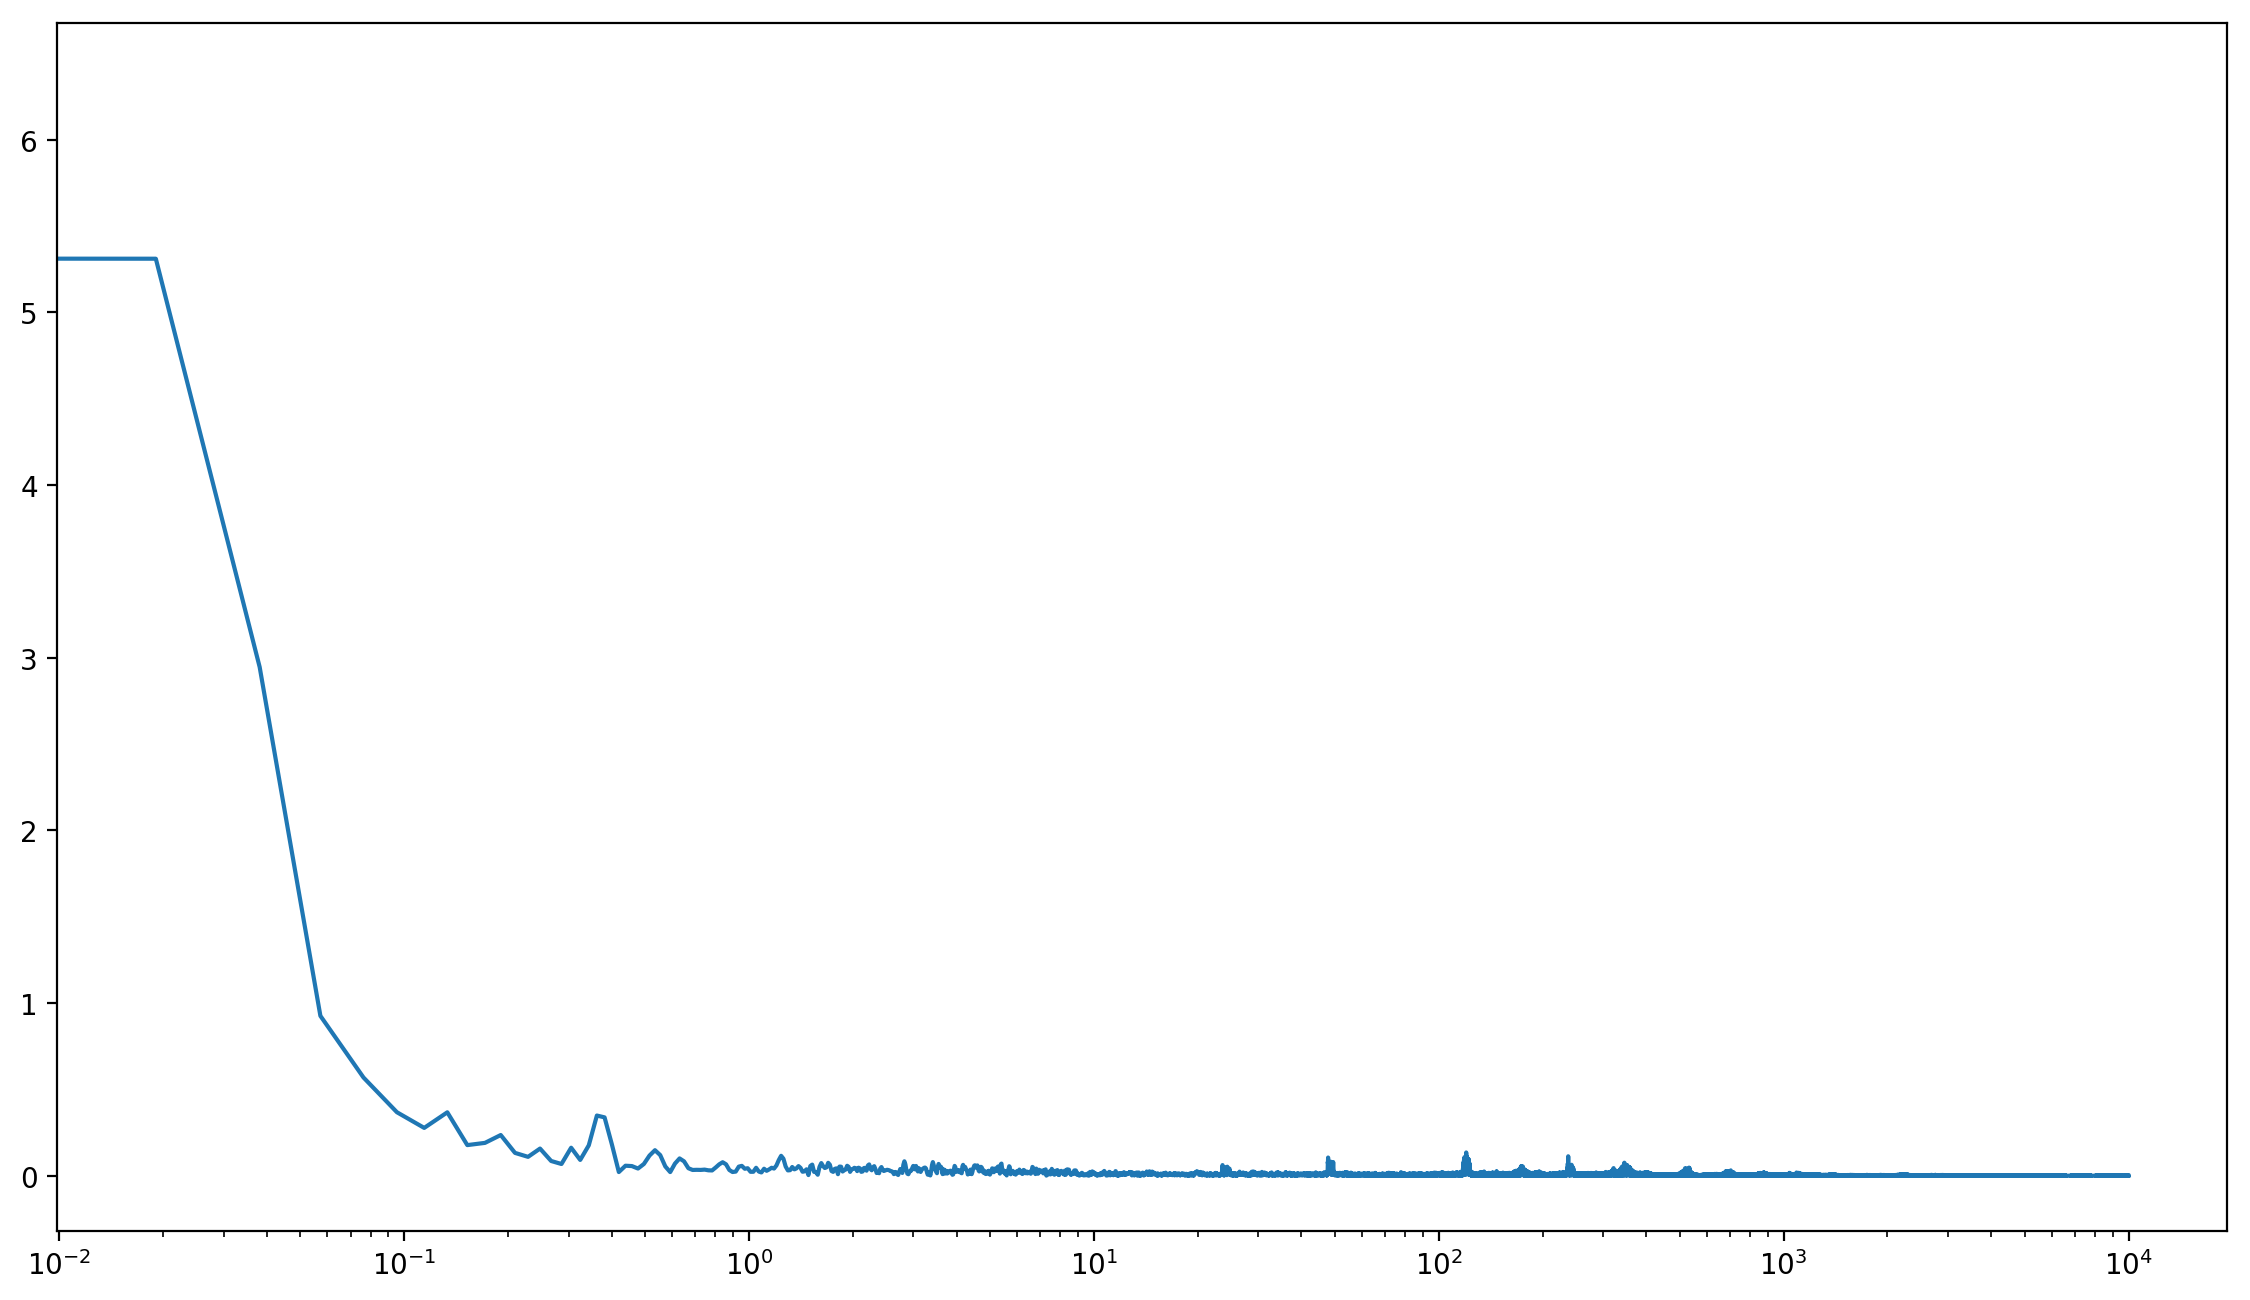

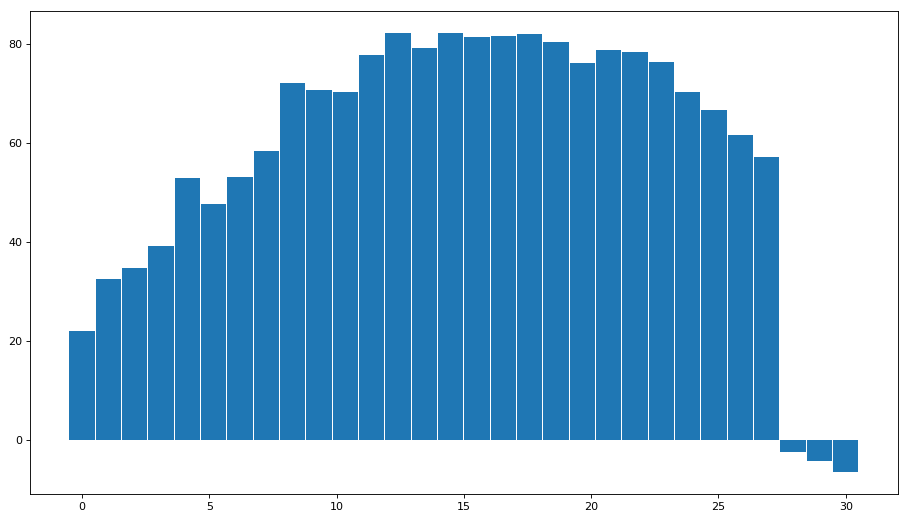

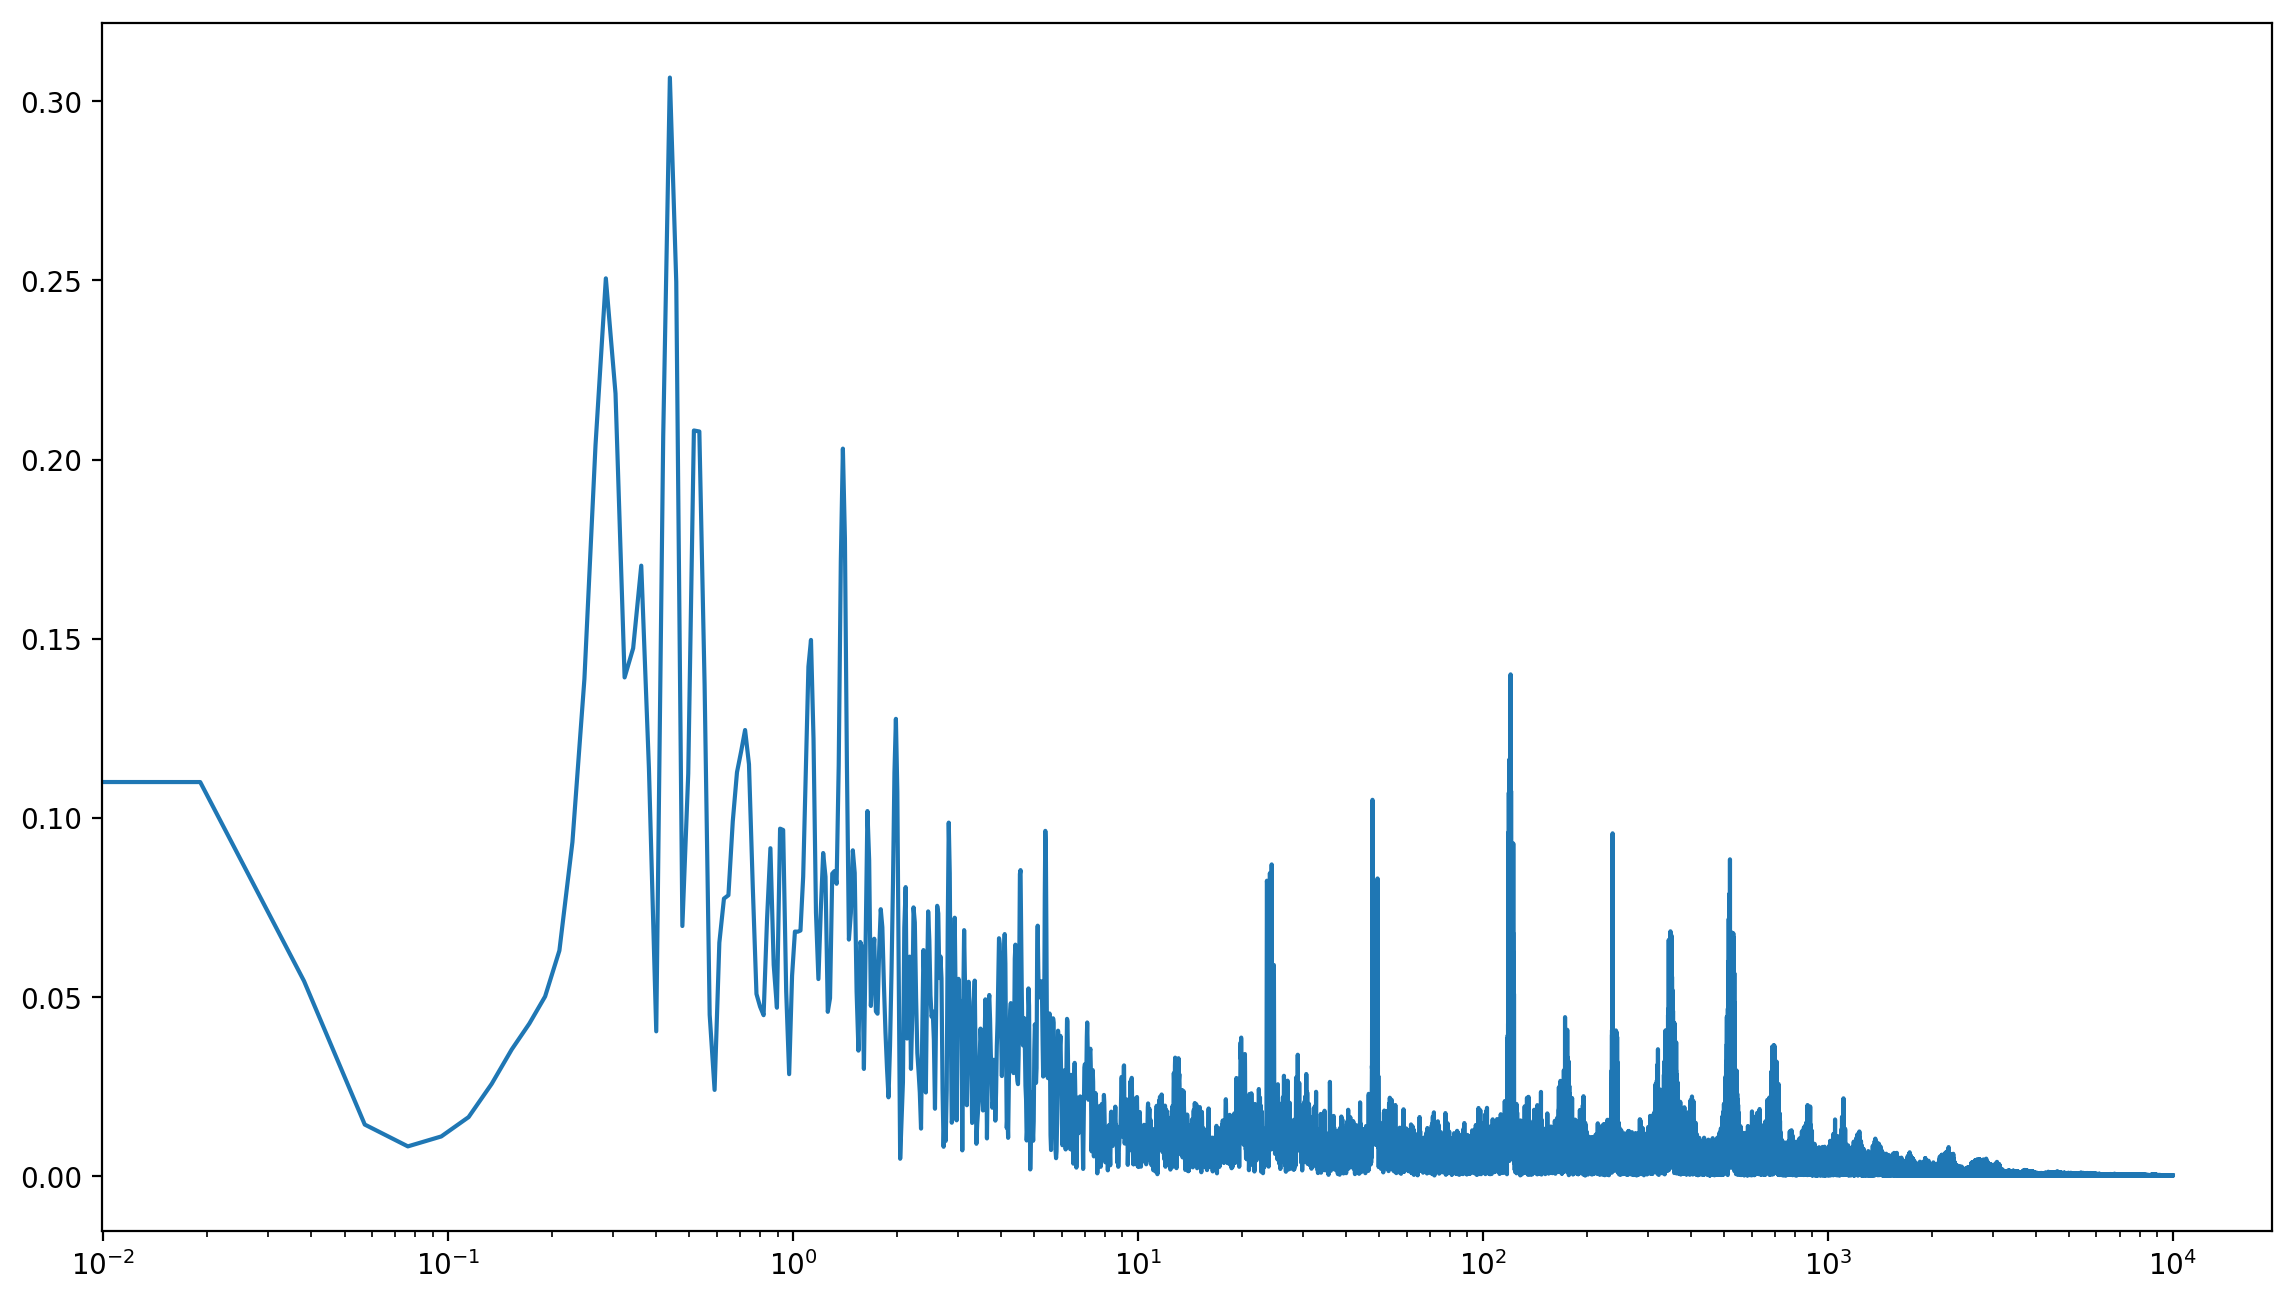

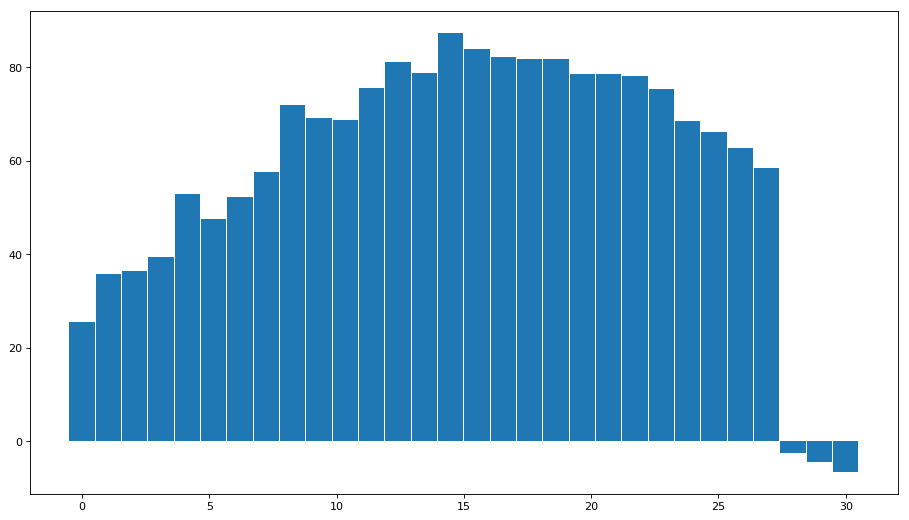

In [8]:
if __name__ == '__main__':
    
    #读入文件地址
    ads = 'C:/Users/44581/Desktop/test/7.31_6-8_9.xlsx'
    #采集频率
    measure_frqs = 20000

    for i in range(13,17):
        out_non,out_A, non, A = calculate(ads, measure_frqs, freqs_3[3:34], Wght_fct[3:33],i)
        print("number of chanal: " , i)
        print("non=",non)
        print(out_non)
        print("A=",A)
        print(out_A)
        plt.figure(figsize=(14,8), dpi=80)
        plt.bar(np.linspace(0,30,30),out_A,1,align='center')